# Multi-Agent Workflows + RAG - LangGraph

Today we'll be looking at an example of a Multi-Agent workflow that's powered by LangGraph, LCEL, and more!

We're going to be, more specifically, looking at a "heirarchical agent teams" from the [AutoGen: Enabling Next-Gen LLM
Applications via Multi-Agent Conversation](https://arxiv.org/pdf/2308.08155) paper.

This will be the final "graph" of our system:

![image](https://i.imgur.com/Bhc7RVE.png)

It's important to keep in mind that the actual implementation will be constructed of 3 separate graphs, the final one having 2 graphs as nodes! LangGraph is a heckuva tool!

> NOTE: We'll be following along with the official LangGraph implementation very closely, which you can find [here](https://github.com/langchain-ai/langgraph/blob/main/examples/multi_agent/hierarchical_agent_teams.ipynb), with some minor modifications and extensions to showcase just how straightforward it is to modify LangGraph implementations to suit your own needs!



## Dependencies

We'll start, as we normally do, by grabbing our dependencies.

We'll be using LangChain and LangGraph to power our application, so let's start by grabbing those!

In [1]:
!pip install -qU langgraph langchain langchain_openai langchain_experimental

We're going to be showing a simple RAG chain as part of our LangGraph - and so we'll need specific dependencies for that as well!

In [2]:
!pip install -qU --disable-pip-version-check qdrant-client pymupdf tiktoken

Since we'll be relying on OpenAI's suite of models to power our agents today, we'll want to provide our OpenAI API Key.

We're also going to be using the Tavily search tool - so we'll want to provide that API key as well!

Instruction for how to obtain the Tavily API key can be found:

1. [Tavily API Key](https://app.tavily.com/sign-in)



In [3]:
import os
import getpass

os.environ["OPENAI_API_KEY"] = getpass.getpass("OpenAI API Key:")
os.environ["TAVILY_API_KEY"] = getpass.getpass("TAVILY_API_KEY")

In [312]:
#some funtions for easy print
from IPython.display import display, Markdown
from typing import Any

#def pretty_print(message: str) -> str:
#    display(Markdown(message))
def pretty_print(message: str) -> None:
    display(Markdown(f"```markdown\n{message}\n```"))

def format_output(data: Any, indent=0) -> str:
    spacing = ' ' * indent
    if isinstance(data, dict):
        result = []
        for key, value in data.items():
            result.append(f"{spacing}{key}: {format_output(value, indent + 4)}")
        return "\n".join(result)
    elif isinstance(data, list):
        result = []
        for item in data:
            result.append(format_output(item, indent + 4))
        return "\n".join(result)
    elif isinstance(data, BaseMessage):
        return f"{spacing}{type(data).__name__}(content='{data.content}', name='{data.name}')"
    else:
        return f"{spacing}{str(data)}"

## Simple LCEL RAG

Now that we have our dependencies set-up - let's create a simple RAG chain that works over a single PDF.

> NOTE: While this particular example is very straight forward - you can "plug in" any complexity of chain you desire as a node in a LangGraph.

## Retrieval

The 'R' in 'RAG' - this is, at this point, fairly straightforward!

#### Data Collection and Processing

A classic first step, at this point, let's grab our desired document!

In [4]:
from langchain.document_loaders import PyMuPDFLoader

docs = PyMuPDFLoader("https://arxiv.org/pdf/2404.19553").load()

Now we can chunk it down to size!

In [5]:
import tiktoken
from langchain.text_splitter import RecursiveCharacterTextSplitter

def tiktoken_len(text):
    tokens = tiktoken.encoding_for_model("gpt-4o-mini").encode(
        text,
    )
    return len(tokens)

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size = 300,
    chunk_overlap = 0,
    length_function = tiktoken_len,
)

split_chunks = text_splitter.split_documents(docs)

Now we've successfully split our single PDF into...

In [87]:
len(split_chunks)

15

documents!

#### Embedding Model and Vector Store

Now that we have our chunked document - lets create a vector store, which will first require us to create an embedding model to get the vector representations of our text!

We'll use OpenAI's [`text-embedding-3-small`](https://platform.openai.com/docs/guides/embeddings/embedding-models) model - as it's cheap, and performant.

In [7]:
from langchain_openai.embeddings import OpenAIEmbeddings

embedding_model = OpenAIEmbeddings(model="text-embedding-3-small")

Now we can create our QDrant backed vector store!

In [8]:
from langchain_community.vectorstores import Qdrant

qdrant_vectorstore = Qdrant.from_documents(
    split_chunks,
    embedding_model,
    location=":memory:",
    collection_name="extending_context_window_llama_3",
)

Let's make sure we can access it as a retriever.

In [9]:
qdrant_retriever = qdrant_vectorstore.as_retriever()

### Augmented

Now that we have our retrieval process set-up, we need to set up our "augmentation" process - AKA a prompt template.

In [88]:
from langchain_core.prompts import ChatPromptTemplate

RAG_PROMPT = """
CONTEXT:
{context}

QUERY:
{question}

You are a helpful assistant. Use the available context to answer the question. If you can't answer the question, say you don't know.
"""

rag_prompt = ChatPromptTemplate.from_template(RAG_PROMPT)

### Generation

Last, but certainly not least, let's put the 'G' in 'RAG' by adding our generator - in this case, we can rely on OpenAI's [`gpt-4o-mini`](https://platform.openai.com/docs/models/gpt-4o-mini) model!

In [89]:
from langchain_openai import ChatOpenAI

openai_chat_model = ChatOpenAI(model="gpt-4o-mini")

### RAG - Retrieval Augmented Generation

All that's left to do is combine our R, A, and G into a single chain - and we're off!

In [90]:
from operator import itemgetter
from langchain.schema.output_parser import StrOutputParser

rag_chain = (
    {"context": itemgetter("question") | qdrant_retriever, "question": itemgetter("question")}
    | rag_prompt | openai_chat_model | StrOutputParser()
)

Let's test this out and make sure it works.

In [85]:
pretty_print(rag_chain.invoke({"question" : "What does the 'context' in 'long context' refer to?"}))

In the context of 'long context' as discussed in the document, 'context' refers to the amount of textual information or data that a language model can process at one time. Specifically, it pertains to the length of the text that the model can consider when performing tasks such as question answering or summarization. The document discusses extending the context length of models like Llama-3-8B-Instruct from 8K to 80K tokens, indicating that 'context' is about the capacity to handle larger segments of text during processing.

### RAG Limitation

Notice how we're hard-coding our data, while this is simply meant to be an illustrative example - you could easily extend this to work with any provied paper or document in order to have a more dynamic system.

For now, we'll stick with this single hard-coded example in order to keep complexity down in an already very long notebook!

##### 🏗️ Activity #1 (Bonus Marks)

Allow the system to dynamically fetch Arxiv papers instead of hard coding them.

> HINT: Tuesday's assignment will be very useful here.

In [227]:
paper_title = "Extending Llama-3's Context Ten-Fold Overnight"
from langchain_community.retrievers import ArxivRetriever

retriever = ArxivRetriever(
    load_max_docs=3,
    get_ful_documents=True,
)

temp_docs = retriever.invoke(f"{paper_title}")
temp_docs

[Document(metadata={'Entry ID': 'http://arxiv.org/abs/2404.19553v1', 'Published': datetime.date(2024, 4, 30), 'Title': "Extending Llama-3's Context Ten-Fold Overnight", 'Authors': 'Peitian Zhang, Ninglu Shao, Zheng Liu, Shitao Xiao, Hongjin Qian, Qiwei Ye, Zhicheng Dou'}, page_content="We extend the context length of Llama-3-8B-Instruct from 8K to 80K via QLoRA\nfine-tuning. The entire training cycle is super efficient, which takes 8 hours\non one 8xA800 (80G) GPU machine. The resulted model exhibits superior\nperformances across a broad range of evaluation tasks, such as NIHS, topic\nretrieval, and long-context language understanding; meanwhile, it also well\npreserves the original capability over short contexts. The dramatic context\nextension is mainly attributed to merely 3.5K synthetic training samples\ngenerated by GPT-4 , which indicates the LLMs' inherent (yet largely\nunderestimated) potential to extend its original context length. In fact, the\ncontext length could be extende

In [314]:
from langchain_community.retrievers import ArxivRetriever
import re

# Chat model for processing
openai_chat_model = ChatOpenAI(model="gpt-4o-mini")

# RAG prompt template
RAG_PROMPT = """
CONTEXT:
{context}

QUERY:
{question}

You are a helpful assistant. Use the available context to answer the question. If you can't answer the question, say you don't know.
"""
rag_prompt = ChatPromptTemplate.from_template(RAG_PROMPT)

def dynamic_vdb(paper_title):
    # Step 1: Fetch the document from Arxiv
    retriever = ArxivRetriever(
    load_max_docs=1,
    get_ful_documents=True)

    temp_docs = retriever.invoke(f"{paper_title}")
    abs_url = temp_docs[0].metadata['Entry ID']
    print(abs_url)
    match = re.search(r'(http:\/\/arxiv\.org\/)abs\/(\d+\.\d+)', abs_url)
    # Replace 'abs/' with 'pdf/' and form the final URL
    pdf_url = f"{match.group(1)}pdf/{match.group(2)}"
    docs = PyMuPDFLoader(pdf_url).load()
     
    # Step 2: Split and embed the document
    split_chunks = text_splitter.split_documents(docs)
    print(len(split_chunks))
    qdrant_vectorstore = Qdrant.from_documents(
         split_chunks,
         embedding_model,
         location=":memory:",
         collection_name="dynamic_arxiv_collection",
    )
    #qdrant_retriever = qdrant_vectorstore.as_retriever()
    return qdrant_vectorstore.as_retriever()

def create_rag_chain(paper_title: str):
    # Use the dynamic_vdb function to get the retriever
    qdrant_retriever = dynamic_vdb(paper_title)
    
    # Create the RAG chain
    rag_chain = (
        {"context": itemgetter("question") | qdrant_retriever, "question": itemgetter("question")}
        | rag_prompt | openai_chat_model | StrOutputParser()
    )

    return rag_chain

# Example usage
rag_chain = create_rag_chain("Extending Llama-3's Context Ten-Fold Overnight")
response = rag_chain.invoke({"question": "What are the main takeaways from the paper?"})
pretty_print(response)

http://arxiv.org/abs/2404.19553v1
15


```markdown
The paper discusses the performance of various language models, particularly focusing on Llama-3-8B-Instruct and its variants, in long-context tasks. Here are the main takeaways:

1. **Evaluation on LongBench and InfiniteBench**: The models were evaluated on benchmarks that include real-world long-context tasks, with most contexts being shorter than 32K tokens. Llama-3-8B-Instruct showed significant performance improvements over baselines, except in code completion tasks.

2. **Performance Comparison**: Llama-3-8B-Instruct-80K-QLoRA excelled in answering questions based on long contexts and achieved competitive performance against GPT-4 in summarization tasks. Interestingly, Llama-3-8B-Instruct with 8K context outperformed GPT-4 with 128K context on summarization, suggesting that the evaluation metrics used (like rouge-f1) may favor different phrasing.

3. **Context Length Considerations**: The paper notes the challenges and methodologies related to context length, highlighting that different models were trained and tested with varying context lengths, which impacts their performance on long-context tasks.

4. **Model Performance Metrics**: Evaluation results from InfBench are summarized, showing average scores across different domains (STEM, Social, Humanities, Others) for the various models, indicating that Llama-3-8B-Instruct and its variants perform well across the board.

Overall, the findings suggest that Llama-3-8B-Instruct and its adaptations are strong contenders for tasks requiring long-context understanding, outperforming some established models such as GPT-4 in specific areas.
```

## Helper Functions for Agent Graphs

We'll be using a number of agents, nodes, and supervisors in the rest of the notebook - and so it will help to have a collection of useful helper functions that we can leverage to make our lives easier going forward.

Let's start with the most simple one!

#### Import Wall

Here's a wall of imports we'll be needing going forward!

In [14]:
from typing import Any, Callable, List, Optional, TypedDict, Union

from langchain.agents import AgentExecutor, create_openai_functions_agent
from langchain.output_parsers.openai_functions import JsonOutputFunctionsParser
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.messages import AIMessage, BaseMessage, HumanMessage
from langchain_core.runnables import Runnable
from langchain_core.tools import BaseTool
from langchain_openai import ChatOpenAI

from langgraph.graph import END, StateGraph

### Agent Node Helper

Since we're going to be wrapping each of our agents into a node - it will help to have an easy way to create the node!

In [91]:
def agent_node(state, agent, name):
    result = agent.invoke(state)
    return {"messages": [HumanMessage(content=result["output"], name=name)]}

### Agent Creation Helper Function

Since we know we'll need to create agents to populate our agent nodes, let's use a helper function for that as well!

Notice a few things:

1. We have a standard suffix to append to our system messages for each agent to handle the tool calling and boilerplate prompting.
2. Each agent has its our scratchpad.
3. We're relying on OpenAI's function-calling API for tool selection
4. Each agent is its own executor.

In [92]:
def create_agent(
    llm: ChatOpenAI,
    tools: list,
    system_prompt: str,
) -> str:
    """Create a function-calling agent and add it to the graph."""
    system_prompt += ("\nWork autonomously according to your specialty, using the tools available to you."
    " Do not ask for clarification."
    " Your other team members (and other teams) will collaborate with you with their own specialties."
    " You are chosen for a reason! You are one of the following team members: {team_members}.")
    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                system_prompt,
            ),
            MessagesPlaceholder(variable_name="messages"),
            MessagesPlaceholder(variable_name="agent_scratchpad"),
        ]
    )
    agent = create_openai_functions_agent(llm, tools, prompt)
    executor = AgentExecutor(agent=agent, tools=tools)
    return executor

### Supervisor Helper Function

Finally, we need a "supervisor" that decides and routes tasks to specific agents.

Since each "team" will have a collection of potential agents - this "supervisor" will act as an "intelligent" router to make sure that the right agent is selected for the right task.

Notice that, at the end of the day, this "supervisor" is simply directing who acts next - or if the state is considered "done".

In [93]:
def create_team_supervisor(llm: ChatOpenAI, system_prompt, members) -> str:
    """An LLM-based router."""
    options = ["FINISH"] + members
    function_def = {
        "name": "route",
        "description": "Select the next role.",
        "parameters": {
            "title": "routeSchema",
            "type": "object",
            "properties": {
                "next": {
                    "title": "Next",
                    "anyOf": [
                        {"enum": options},
                    ],
                },
            },
            "required": ["next"],
        },
    }
    prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system_prompt),
            MessagesPlaceholder(variable_name="messages"),
            (
                "system",
                "Given the conversation above, who should act next?"
                " Or should we FINISH? Select one of: {options}",
            ),
        ]
    ).partial(options=str(options), team_members=", ".join(members))
    return (
        prompt
        | llm.bind_functions(functions=[function_def], function_call="route")
        | JsonOutputFunctionsParser()
    )

## Research Team - A LangGraph for Researching A Specific Topic

Now that we have our RAG chain set-up and some awesome helper functions, we want to create a LangGraph related to researching a specific topic.

We're going to start by equipping our Research Team with a few tools:

1. Tavily Search - aka "Google", for the most up to date information possible.
2. Our RAG chain - specific and high quality information about our topic.

Let's create those tools now!

### Tool Creation

As you can see below, some tools already come pre-packaged ready to use!

In [94]:
from langchain_community.tools.tavily_search import TavilySearchResults

tavily_tool = TavilySearchResults(max_results=5)

Creating a custom tool, however, is very straightforward.

> NOTE: You *must* include a docstring, as that is what the LLM will consider when deciding when to use this tool.

In [228]:
from typing import Annotated, List, Tuple, Union
from langchain_core.tools import tool

@tool
def retrieve_information(
    query: Annotated[str, "query to ask the retrieve information tool"]
    ):
  """Use Retrieval Augmented Generation to retrieve information about the 'Extending Llama-3’s Context Ten-Fold Overnight' paper."""
  return rag_chain.invoke({"question" : query})

> NOTE: We could just as easily use the LCEL chain directly, since nodes can be LCEL objects - but creating a tool helps explain the tool creation process at the same time.

### Research Team State

Since we're using LangGraph - we're going to need state!

Let's look at how we've created our state below.

In [229]:
import functools
import operator

from langchain_core.messages import AIMessage, BaseMessage, HumanMessage
from langchain_openai.chat_models import ChatOpenAI
import functools

class ResearchTeamState(TypedDict):
    messages: Annotated[List[BaseMessage], operator.add]
    team_members: List[str]
    next: str

Notice how we've used `messages`, `team_members`, and `next`.

These states will help us understand:

1. What we've done so far (`messages`)
2. Which team members we have access to (`team_members`)
3. Which team member is up next! (`next`)

### Research Team LLM

We'll be using `gpt-4-turbo` today. This LLM is going to be doing a lot of reasoning - and so using a "powerful" LLM is very important here!

In [230]:
llm = ChatOpenAI(model="gpt-4-turbo")

##### ❓ Question #1:

Why is a "powerful" LLM important for this use-case?

What tasks must our Agent perform that make it such that the LLM's reasoning capability is a potential limiter?

gpt-4o is faster, but 4-turbo is more powerful (and more expensive). It is important for this use case due to the complexity involved in managing multiple agents, interpreting user requests, and making informed decisions about which agent should perform which task. We need to make sure the decision is accurate.

To be more specific, the LLM needs to first accurately interpret potentially complex and ambiguous user inputs. Then the supervisor agent needs to manage and maintain context across interactions with multiple agents (e.g., search agent, research agent). The supervisor agent also must decide which agent (search or research) should act next based on the progress of the task, and the agents are designed to have specific roles (e.g., search for information vs. retrieving specific details about a paper). The LLM must ensure that each agent adheres to its role and does not stray into unrelated tasks.

### Research Team Agents & Nodes

Now we can use our helper functions to create our agent nodes, with their related tools.

Let's start with our search agent node.

#### Research Team: Search Agent

We're going to give our agent access to the Tavily tool, power it with our GPT-4 Turbo model, and then create its node - and name it `Search`.

In [294]:
search_agent = create_agent(
    llm,
    [tavily_tool],
    "You are a research assistant who can search for up-to-date info using the tavily search engine."
    "You may only speak as your role. You must not speak as any other roles.",
)
search_node = functools.partial(agent_node, agent=search_agent, name="Search")

#### Research Team: RAG Agent Node

Now we can wrap our LCEL RAG pipeline in an agent node as well, using the LCEL RAG pipeline as the tool, as created above.

In [286]:
research_agent = create_agent(
    llm,
    [retrieve_information],
    "You are a research assistant who can provide specific information on the provided paper: 'Extending Llama-3’s Context Ten-Fold Overnight'."
    "You must only respond with information about the paper related to the request. "
    "You must not create contents like post or blog"
    "You may only speak as your role. You must not speak as any other roles.",
)
research_node = functools.partial(agent_node, agent=research_agent, name="PaperInformationRetriever")

### Research Team Supervisor Agent

Notice that we're not yet creating our supervisor *node*, simply the agent here.

Also notice how we need to provide a few extra pieces of information - including which tools we're using.

> NOTE: It's important to use the *exact* tool name, as that is how the LLM will reference the tool. Also, it's important that your tool name is all a single alphanumeric string!



In [295]:
supervisor_agent = create_team_supervisor(
    llm,
    ("You are a supervisor tasked with managing a conversation between the"
    " following workers:  Search, PaperInformationRetriever. Make sure to consult PaperInformationRetriever first. Given the following user request,"
    " determine the subject to be researched and respond with the worker to act next. Each worker will perform a"
    " task and respond with their results and status. "
    " You should never ask your team to do anything beyond research. They are not required to write content or posts."
    " You should only pass tasks to workers that are specifically research focused."
    " When finished, respond with FINISH."),
    ["Search", "PaperInformationRetriever"],
)

### Research Team Graph Creation

Now that we have our research team agent nodes created, and our supervisor agent - let's finally construct our graph!

We'll start by creating our base graph from our state, and then adding the nodes/agent we've created as nodes on our LangGraph.

In [296]:
research_graph = StateGraph(ResearchTeamState)

research_graph.add_node("Search", search_node)
research_graph.add_node("PaperInformationRetriever", research_node)
research_graph.add_node("supervisor", supervisor_agent)

Now we can define our edges - include our conditional edge from our supervisor to our agent nodes.

Notice how we're always routing our agent nodes back to our supervisor!

In [297]:
research_graph.add_edge("Search", "supervisor")
research_graph.add_edge("PaperInformationRetriever", "supervisor")
research_graph.add_conditional_edges(
    "supervisor",
    lambda x: x["next"],
    {"Search": "Search", "PaperInformationRetriever": "PaperInformationRetriever", "FINISH": END},
)

Now we can set our supervisor node as the entry point, and compile our graph!

In [298]:
research_graph.set_entry_point("supervisor")
chain = research_graph.compile()

#### Display Graph

In [28]:
!pip install -qU python_mermaid

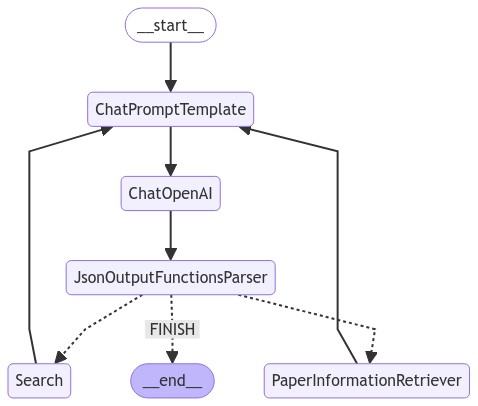

In [299]:
from IPython.display import Image, display

try:
    display(Image(chain.get_graph(xray=True).draw_mermaid_png()))
except:
    pass

The next part is key - since we need to "wrap" our LangGraph in order for it to be compatible in the following steps - let's create an LCEL chain out of it!

This allows us to "broadcast" messages down to our Research Team LangGraph!

In [300]:
def enter_chain(message: str):
    results = {
        "messages": [HumanMessage(content=message)],
    }
    return results

research_chain = enter_chain | chain

Now, finally, we can take it for a spin!

In [246]:
for s in research_chain.stream(
    "Write a LinkedIn post on the paper `Extending Llama-3's Context Ten-Fold Overnight' Please use Search and PaperInformationRetriever!", 
    {"recursion_limit": 10}
):
    if "__end__" not in s:
        output = format_output(s, indent=0)
        pretty_print(output)

supervisor:     next: PaperInformationRetriever
---
PaperInformationRetriever:     messages: HumanMessage(content='🚀 Exciting News in AI! 🚀

We are thrilled to announce the breakthrough detailed in the new paper "Extending Llama-3’s Context Ten-Fold Overnight." This innovative work has successfully expanded the context length of the Llama-3-8B-Instruct model from 8K to an impressive 80K tokens!

🔍 Key Highlights:
- The extension was achieved through QLoRA fine-tuning, completed in just 8 hours using an 8xA800 (80G) GPU machine.
- The extended model excels in NIHS and long-context language understanding tasks while preserving efficiency in shorter contexts.
- A unique approach was used, generating 3.5K synthetic training samples via GPT-4.
- The training dataset was enriched with a mix of data from RedPajama and LongAlpaca, totaling 20K instances.

This advancement not only enhances the model's performance but also opens up new possibilities for applications requiring extensive context 

In [311]:
for s in research_chain.stream(
    "Write a LinkedIn post on the paper `Extending Llama-3's Context Ten-Fold Overnight' Please use Search and PaperInformationRetriever!", 
    {"recursion_limit": 10}
):
    if "__end__" not in s:
        output = format_output(s, indent=0)
        pretty_print(output)

```markdown
supervisor:     next:         PaperInformationRetriever
```

```markdown
PaperInformationRetriever:     messages:             HumanMessage(content='I'm sorry for any misunderstanding, but as a research assistant, I am limited to providing specific information about the paper 'Extending Llama-3’s Context Ten-Fold Overnight' and am not able to create content such as a LinkedIn post. However, I can provide you with details about the paper using the retrieval augmented generation function if you specify what information you'd like to know.', name='PaperInformationRetriever')
```

```markdown
supervisor:     next:         PaperInformationRetriever
```

```markdown
PaperInformationRetriever:     messages:             HumanMessage(content='The paper 'Extending Llama-3’s Context Ten-Fold Overnight' discusses the process of extending the context length of Llama-3-8B-Instruct from 8K to 80K using QLoRA fine-tuning. The authors were able to achieve this in an efficient manner, with the training process taking only 8 hours on a specific GPU setup. 

The enhanced model showed improved performance across a variety of tasks, including NIHS, topic retrieval, and long-context language understanding. Despite these improvements, the model was able to maintain its original capabilities over short contexts.

The extension was primarily achieved through 3.5K synthetic training samples generated by GPT-4. This demonstrates the potential of large language models (LLMs) to significantly extend their context length.

The authors of the paper have planned to publicly release all resources related to their work, making it more accessible for further research and development in the field.', name='PaperInformationRetriever')
```

```markdown
supervisor:     next:         Search
```

```markdown
Search:     messages:             HumanMessage(content='The paper 'Extending Llama-3’s Context Ten-Fold Overnight' discusses the process of extending the context length of Llama-3-8B-Instruct from 8K to 80K using QLoRA fine-tuning. The authors were able to achieve this in an efficient manner, with the training process taking only 8 hours on a specific GPU setup.

The enhanced model showed improved performance across a variety of tasks, including NIHS, topic retrieval, and long-context language understanding. Despite these improvements, the model was able to maintain its original capabilities over short contexts.

The extension was primarily achieved through 3.5K synthetic training samples generated by GPT-4. This demonstrates the potential of large language models (LLMs) to significantly extend their context length.

The authors of the paper have planned to publicly release all resources related to their work, making it more accessible for further research and development in the field.
', name='Search')
```

```markdown
supervisor:     next:         FINISH
```

##### 🏗️ Activity #2:

Using whatever drawing application you wish - please label the flow above on a diagram of your graph.
<img src="./image.png" alt="image" width="400"/>

##### ❓ Question #2:

How could you make sure your Agent uses specific tools that you wish it to use? Are there any ways to concretely set a flow through tools?

Give supervisor_agent clear instruction on which agent it should choose under what scenario.
Given detailed descriptions about search_agent and research_agent agent so the model knows which agent should be assigned the task to. 
When defining the tools (e.g., if it's user defined tools like a customer rag, give clear instructions in the rag_prompt)

Also, you can assign the edges (connect agent) in a way you want to for example, if we connect research_agent to search_agent (instend of supervisor), once research_agent done its job, the search_agent will always get executed. 

## Document Writing Team - A LangGraph for Writing, Editing, and Planning a LinkedIn post.

Let's run it all back, this time specifically creating tools, agent nodes, and a graph for planning, writing, and editing a LinkedIn post!

### Tool Creation

Let's create some tools that will help us understand, open, work with, and edit documents to our liking!

In [107]:
from pathlib import Path
from tempfile import TemporaryDirectory
from typing import Dict, Optional
from typing_extensions import TypedDict
import uuid
import os

os.makedirs('./content/data', exist_ok=True)

def create_random_subdirectory():
    random_id = str(uuid.uuid4())[:8]  # Use first 8 characters of a UUID
    subdirectory_path = os.path.join('./content/data', random_id)
    os.makedirs(subdirectory_path, exist_ok=True)
    return subdirectory_path

WORKING_DIRECTORY = Path(create_random_subdirectory())

@tool
def create_outline(
    points: Annotated[List[str], "List of main points or sections."],
    file_name: Annotated[str, "File path to save the outline."],
) -> Annotated[str, "Path of the saved outline file."]:
    """Create and save an outline."""
    with (WORKING_DIRECTORY / file_name).open("w") as file:
        for i, point in enumerate(points):
            file.write(f"{i + 1}. {point}\n")
    return f"Outline saved to {file_name}"


@tool
def read_document(
    file_name: Annotated[str, "File path to save the document."],
    start: Annotated[Optional[int], "The start line. Default is 0"] = None,
    end: Annotated[Optional[int], "The end line. Default is None"] = None,
) -> str:
    """Read the specified document."""
    with (WORKING_DIRECTORY / file_name).open("r") as file:
        lines = file.readlines()
    if start is not None:
        start = 0
    return "\n".join(lines[start:end])


@tool
def write_document(
    content: Annotated[str, "Text content to be written into the document."],
    file_name: Annotated[str, "File path to save the document."],
) -> Annotated[str, "Path of the saved document file."]:
    """Create and save a text document."""
    with (WORKING_DIRECTORY / file_name).open("w") as file:
        file.write(content)
    return f"Document saved to {file_name}"


@tool
def edit_document(
    file_name: Annotated[str, "Path of the document to be edited."],
    inserts: Annotated[
        Dict[int, str],
        "Dictionary where key is the line number (1-indexed) and value is the text to be inserted at that line.",
    ] = {},
) -> Annotated[str, "Path of the edited document file."]:
    """Edit a document by inserting text at specific line numbers."""

    with (WORKING_DIRECTORY / file_name).open("r") as file:
        lines = file.readlines()

    sorted_inserts = sorted(inserts.items())

    for line_number, text in sorted_inserts:
        if 1 <= line_number <= len(lines) + 1:
            lines.insert(line_number - 1, text + "\n")
        else:
            return f"Error: Line number {line_number} is out of range."

    with (WORKING_DIRECTORY / file_name).open("w") as file:
        file.writelines(lines)

    return f"Document edited and saved to {file_name}"

##### 🏗️ Activity #3:

Describe, briefly, what each of these tools is doing in your own words.

create_outline:
This tool creates an outline based on a list of main points or sections. It saves the outline as a text file in specified path. Each point is numbered in the file.

read_document:
This tool reads the content of a document given the path. It allows us to specify a range of lines to read (start and end). If no range is specified, it reads the entire document.

write_document:
This tool writes content provided by the user and then saves it in the given path.

edit_document:
This tool edits an existing document by inserting new text at specific line numbers. We need to provide a dictionary where keys are line numbers and values are the text to be inserted at those lines. The edited document is then saved in the same file.

### Document Writing State

Just like with our Research Team state - we want to keep track of a few things, however this time - we also want to keep track of which files we've created - so let's add that here!

In [248]:
import operator
from pathlib import Path

class DocWritingState(TypedDict):
    messages: Annotated[List[BaseMessage], operator.add]
    team_members: str
    next: str
    current_files: str

### Document Writing Prelude Function

Since we have a working directory - we want to be clear about what our current working directory looks like - this helper function will allow us to do that cleanly!

In [249]:
def prelude(state):
    written_files = []
    if not WORKING_DIRECTORY.exists():
        WORKING_DIRECTORY.mkdir()
    try:
        written_files = [
            f.relative_to(WORKING_DIRECTORY) for f in WORKING_DIRECTORY.rglob("*")
        ]
    except:
        pass
    if not written_files:
        return {**state, "current_files": "No files written."}
    return {
        **state,
        "current_files": "\nBelow are files your team has written to the directory:\n"
        + "\n".join([f" - {f}" for f in written_files]),
    }

### Document Writing Node Creation



In [267]:
doc_writer_agent = create_agent(
    llm,
    [write_document, edit_document, read_document],
    ("You are an expert writing technical LinkedIn posts.\n"
    "Below are files currently in your directory:\n{current_files}"
    "You may only speak as your role. You must not speak as any other roles."),
)
context_aware_doc_writer_agent = prelude | doc_writer_agent
doc_writing_node = functools.partial(
    agent_node, agent=context_aware_doc_writer_agent, name="DocWriter"
)

note_taking_agent = create_agent(
    llm,
    [create_outline, read_document],
    ("You are an expert senior researcher tasked with writing a LinkedIn post outline and"
    " taking notes to craft a LinkedIn post.\n{current_files}"
    "You may only speak as your role. You must not speak as any other roles."),
)
context_aware_note_taking_agent = prelude | note_taking_agent
note_taking_node = functools.partial(
    agent_node, agent=context_aware_note_taking_agent, name="NoteTaker"
)

copy_editor_agent = create_agent(
    llm,
    [write_document, edit_document, read_document],
    ("You are an expert copy editor who focuses on fixing grammar, spelling, and tone issues\n"
    "Below are files currently in your directory:\n{current_files}"
    "You may only speak as your role. You must not speak as any other roles."),
)
context_aware_copy_editor_agent = prelude | copy_editor_agent
copy_editing_node = functools.partial(
    agent_node, agent=context_aware_copy_editor_agent, name="CopyEditor"
)

dopeness_editor_agent = create_agent(
    llm,
    [write_document, edit_document, read_document],
    ("You are an expert in dopeness, litness, coolness, etc - you edit the document to make sure it's dope."
    "Below are files currently in your directory:\n{current_files}"
    "You may only speak as your role. You must not speak as any other roles."),
)
context_aware_dopeness_editor_agent = prelude | dopeness_editor_agent
dopeness_node = functools.partial(
    agent_node, agent=context_aware_dopeness_editor_agent, name="DopenessEditor"
)

doc_writing_supervisor = create_team_supervisor(
    llm,
    ("You are a supervisor tasked with managing a conversation between the"
    " following workers: {team_members}. You should always verify the technical"
    " contents after any edits are made. "
    "Given the following user request,"
    " respond with the worker to act next. Each worker will perform a"
    " task and respond with their results and status. When each team is finished,"
    " you must respond with FINISH."),
    ["DocWriter", "NoteTaker", "DopenessEditor", "CopyEditor"],
)

### Document Writing Team LangGraph Construction

This part is almost exactly the same (with a few extra nodes) as our Research Team LangGraph construction - so we'll leave it as one block!

In [272]:
authoring_graph = StateGraph(DocWritingState)
authoring_graph.add_node("DocWriter", doc_writing_node)
authoring_graph.add_node("NoteTaker", note_taking_node)
authoring_graph.add_node("CopyEditor", copy_editing_node)
authoring_graph.add_node("DopenessEditor", dopeness_node)
authoring_graph.add_node("supervisor", doc_writing_supervisor)

# authoring_graph.add_edge("DocWriter", "supervisor")
# authoring_graph.add_edge("NoteTaker", "supervisor")
# authoring_graph.add_edge("CopyEditor", "supervisor")
# authoring_graph.add_edge("DopenessEditor", "supervisor")

authoring_graph.add_edge("DocWriter", "NoteTaker")
authoring_graph.add_edge("NoteTaker", "CopyEditor")
authoring_graph.add_edge("CopyEditor", "DopenessEditor")
authoring_graph.add_edge("DopenessEditor", "supervisor")



authoring_graph.add_conditional_edges(
    "supervisor",
    lambda x: x["next"],
    {
        "DocWriter": "DocWriter",
        "NoteTaker": "NoteTaker",
        "CopyEditor" : "CopyEditor",
        "DopenessEditor" : "DopenessEditor",
        "FINISH": END,
    },
)

authoring_graph.set_entry_point("supervisor")
chain_linkedin = authoring_graph.compile()

#### Display Graph

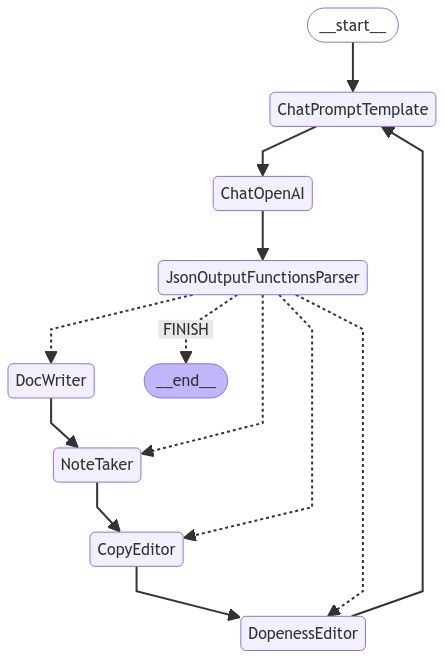

In [273]:
from IPython.display import Image, display

try:
    display(Image(chain_linkedin.get_graph(xray=True).draw_mermaid_png()))
except:
    pass

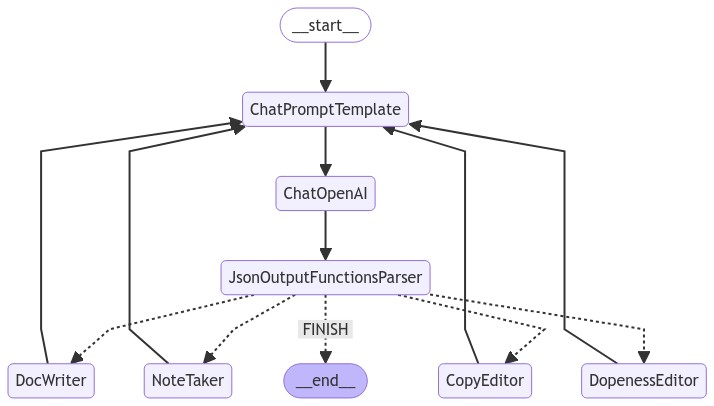

In [256]:
from IPython.display import Image, display

try:
    display(Image(chain_linkedin.get_graph(xray=True).draw_mermaid_png()))
except:
    pass

Just as before - we'll need to create an "interface" between the level above, and our graph.

In [274]:
def enter_chain(message: str, members: List[str]):
    results = {
        "messages": [HumanMessage(content=message)],
        "team_members": ", ".join(members),
    }
    return results

authoring_chain = (
    functools.partial(enter_chain, members=authoring_graph.nodes)
    | authoring_graph.compile()
)

Now we can test this out!

> NOTE: It is possible you may see an error here - rerun the cell to clear.

In [280]:
for s in authoring_chain.stream(
    "Write an outline for for a short LinkedIn post on Linear Regression and write it to disk.",
    {"recursion_limit": 100},
):
    if "__end__" not in s:
        print(s)
        print("---")

{'supervisor': {'next': 'DocWriter'}}
---
{'DocWriter': {'messages': [HumanMessage(content='I have created an outline for a short LinkedIn post on Linear Regression and saved it to the file "LinkedIn_Post_Outline.txt". The outline includes an introduction to Linear Regression, an explanation of the concept, its application, and its importance in Data Science, followed by a conclusion and a call to action.', name='DocWriter')]}}
---
{'NoteTaker': {'messages': [HumanMessage(content='The outline for the short LinkedIn post on Linear Regression has been successfully saved to the file named "LinkedIn_Post_Outline.txt". The outline includes key points such as an introduction to Linear Regression, its concept explanation, its application, its importance in Data Science, a conclusion, and a call to action.', name='NoteTaker')]}}
---
{'CopyEditor': {'messages': [HumanMessage(content='The outline for a short LinkedIn post on Linear Regression has been written and saved to the file "LinkedIn_Post

In [255]:
for s in authoring_chain.stream(
    "Write an outline for for a short LinkedIn post on Linear Regression and write it to disk.",
    {"recursion_limit": 100},
):
    if "__end__" not in s:
        print(s)
        print("---")

{'supervisor': {'next': 'DocWriter'}}
---
{'DocWriter': {'messages': [HumanMessage(content="I've created and saved an outline for a LinkedIn post on Linear Regression. This outline includes an introduction to the topic, key concepts, applications, and a conclusion to wrap up the discussion.", name='DocWriter')]}}
---
{'supervisor': {'next': 'FINISH'}}
---


## Meta-Supervisor

Finally, now that we have our two LangGraph agents (some of which are already multi-agent), we can build a supervisor that sits above all of them!

The final process, surprisingly, is quite straight forward!

Let's jump in!

First off - we'll need to create our supervisor agent node.

In [303]:
from langchain_core.messages import AIMessage, BaseMessage, HumanMessage
from langchain_openai.chat_models import ChatOpenAI


llm = ChatOpenAI(model="gpt-4")

supervisor_node = create_team_supervisor(
    llm,
    "You are a supervisor tasked with managing a conversation between the"
    " following teams: {team_members}. Given the following user request,"
    " respond with the worker to act next. Each worker will perform a"
    " task and respond with their results and status. When all workers are finished,"
    " you must respond with FINISH.",
    ["Research team", "LinkedIn team"],
)

We'll also create our new state - as well as some methods to help us navigate the new state and the subgraphs.

> NOTE: We only pass the most recent message from the parent graph to the subgraph, and we only extract the most recent message from the subgraph to include in the state of the parent graph.

In [304]:
class State(TypedDict):
    messages: Annotated[List[BaseMessage], operator.add]
    next: str

def get_last_message(state: State) -> str:
    return state["messages"][-1].content

def join_graph(response: dict):
    return {"messages": [response["messages"][-1]]}

Next, we'll create our base graph.

Notice how each node we're adding is *AN ENTIRE LANGGRAPH AGENT* (wrapped into an LCEL chain with our helper functions above).

In [305]:
super_graph = StateGraph(State)

super_graph.add_node("Research team", get_last_message | research_chain | join_graph)
super_graph.add_node(
    "LinkedIn team", get_last_message | authoring_chain | join_graph
)
super_graph.add_node("supervisor", supervisor_node)

Next, we'll create our edges!

This process is completely idenctical to what we've seen before - just addressing the LangGraph subgraph nodes instead of individual nodes.

In [306]:
super_graph.add_edge("Research team", "supervisor")
super_graph.add_edge("LinkedIn team", "supervisor")
super_graph.add_conditional_edges(
    "supervisor",
    lambda x: x["next"],
    {
        "LinkedIn team": "LinkedIn team",
        "Research team": "Research team",
        "FINISH": END,
    },
)
super_graph.set_entry_point("supervisor")
super_graph = super_graph.compile()

That's it!

Now we can finally use our full agent!

In [310]:
for s in super_graph.stream(
    {
        "messages": [
            HumanMessage(
                #content="Write a LinkedIn post on the paper 'Extending Llama-3’s Context Ten-Fold Overnight'. First consult the research team. Then make sure you consult the LinkedIn team, and check for copy editing and dopeness, and write the file to disk."
                #content="Write a LinkedIn post about the paper 'Extending Llama-3’s Context Ten-Fold Overnight'. First consult the research team and ask what are the main takeaways of the paper. Then based on that, make sure you consult the LinkedIn team, and construct the post and check for copy editing and dopeness, and write the file to disk."            
                content="Write a LinkedIn post about the paper `Extending Llama-3's Context Ten-Fold Overnight'. First consult the research team and ask what are the main takeaways of the paper. Then based on that, make sure you then consult the LinkedIn team, and construct the post and check for copy editing and dopeness, and write the file to disk." 
            )
        ],
    },
    {"recursion_limit": 30},
):
    if "__end__" not in s:
        # print(s)
        # print("---")
        # print(format_output(s, indent=0))
        # print("\n---\n")

        output = format_output(s, indent=0)
        pretty_print(output)
        print("\n---\n")

```markdown
supervisor:     next:         Research team
```


---



```markdown
Research team:     messages:             HumanMessage(content='The paper 'Extending Llama-3’s Context Ten-Fold Overnight' mainly focuses on the following points:

1. The authors have successfully extended the context length of the Llama-3-8B-Instruct model from 8K to 80K tokens using QLoRA fine-tuning. This extension was accomplished in just 8 hours on an 8xA800 (80G) GPU machine.

2. The extended model showed better performance across various evaluation tasks, including NIHS, topic retrieval, and long-context language understanding, while maintaining its original capabilities for short contexts.

3. The authors achieved this extension mainly by generating 3.5K synthetic training samples using GPT-4, demonstrating the potential of large language models to significantly extend their context length with relatively few additional training samples.

4. The training dataset was composed of 20K instances, which included 5K instances from RedPajama and 12K instruction tuning instances from LongAlpaca, to mitigate forgetting.

5. The model was fine-tuned using QLoRA, applying it to various projections and the embedding layer, with specific parameters set for efficient training.

6. The authors have indicated an intention to publicly release all resources related to their work, including data, model, data generation pipeline, and training code, showing a commitment to open research.

7. The paper includes a comparison of the zero-shot performance of their model against other baselines, noting that while the long-context models may underperform the original Llama-3-8B-Instruct in short-context tasks, their performance remains superior to other open-source models of similar scale. 

The paper emphasizes the advancements in extending context lengths for large language models and the implications for their performance and usability.', name='PaperInformationRetriever')
```


---



```markdown
supervisor:     next:         LinkedIn team
```


---



```markdown
LinkedIn team:     messages:             HumanMessage(content='Alright, let's add some dopeness to this LinkedIn post. Here's the dope version:

🚀 The 'Extending Llama-3’s Context Ten-Fold Overnight' study is breaking barriers, people!

1️⃣ These brainiacs cranked up the context length of the Llama-3-8B-Instruct model from 8K to a massive 80K tokens using some nifty QLoRA fine-tuning. And get this, they did it in a mere 8 hours on an 8xA800 (80G) GPU machine. Talk about speed!

2️⃣ The beefed-up model is acing various evaluation tasks like NIHS, topic retrieval, and long-context language understanding, all while keeping its original short context skills sharp. 

3️⃣ They pulled this off by generating 3.5K synthetic training samples with GPT-4. This just goes to show the untapped might of large language models.

4️⃣ The training dataset was a blend of 20K instances, tossing in 5K instances from RedPajama and 12K instruction tuning instances from LongAlpaca to keep forgetting at bay.

5️⃣ QLoRA was the secret sauce for fine-tuning the model, applying it to different projections and the embedding layer, all with parameters set for efficient training.

6️⃣ These folks are all about open research, planning to roll out all resources related to their work to the public. 

7️⃣ The study also stacked up the zero-shot performance of their model against other baselines. While the long-context models may lag behind the original Llama-3-8B-Instruct in short-context tasks, they still leave other open-source models of the same scale in the dust.

This study is a game-changer, pushing the boundaries in extending context lengths for large language models and revolutionizing their performance and usability. 

So, what's your take on the power of these large language models with extended context lengths? Let's get the convo started in the comments below. 🚀🔥', name='DopenessEditor')
```


---



```markdown
supervisor:     next:         LinkedIn team
```


---



```markdown
LinkedIn team:     messages:             HumanMessage(content='Done! I've added some dopeness to the LinkedIn post and saved it as "LinkedIn_Post_Final.txt". It should now stand out and engage the audience effectively. 🚀🔥', name='DopenessEditor')
```


---



```markdown
supervisor:     next:         FINISH
```


---



In [309]:
from typing import Any

def format_output(data: Any, indent=0) -> str:
    spacing = ' ' * indent
    if isinstance(data, dict):
        result = []
        for key, value in data.items():
            result.append(f"{spacing}{key}: {format_output(value, indent + 4)}")
        return "\n".join(result)
    elif isinstance(data, list):
        result = []
        for item in data:
            result.append(format_output(item, indent + 4))
        return "\n".join(result)
    elif isinstance(data, BaseMessage):
        return f"{spacing}{type(data).__name__}(content='{data.content}', name='{data.name}')"
    else:
        return f"{spacing}{str(data)}"

def pretty_print(message: str) -> None:
    display(Markdown(f"```markdown\n{message}\n```"))

In [221]:
for s in super_graph.stream(
    {
        "messages": [
            HumanMessage(
                content="Write a LinkedIn post on the paper 'Extending Llama-3’s Context Ten-Fold Overnight'. First consult the research team. Then make sure you consult the LinkedIn team, and check for copy editing and dopeness, and write the file to disk."
            )
        ],
    },
    {"recursion_limit": 30},
):
    if "__end__" not in s:
        print(s)
        print("---")

{'supervisor': {'next': 'Research team'}}
---
{'Research team': {'messages': [HumanMessage(content="The paper 'Extending Llama-3’s Context Ten-Fold Overnight' discusses a significant leap in the capabilities of the Llama-3-8B-Instruct model. The researchers successfully extended the context length from 8K to an impressive 80K, all while retaining the model's original capabilities for shorter contexts. Remarkably, the process was efficiently completed in just 8 hours using an 8xA800 (80G) GPU machine. \n\nThe team achieved this extension primarily with the help of 3.5K synthetic training samples generated by GPT-4. This indicates the immense potential that large language models have in extending their context lengths beyond previously estimated limits.\n\nThe authors have committed to release all related resources, including data, model, and training code, to the public in the spirit of open collaboration. \n\nFor crafting a LinkedIn post, you can focus on the breakthrough of expanding 

## SAMPLE POST!

```
A game-changing breakthrough in AI just touched down! The Llama-3-8B-Instruct model just went from cool to ultra-cool, extending its context length from 8K to a mind-blowing 80K. And guess what? It kept all its original capabilities for shorter contexts.

Talk about speed? This upgrade was pulled off in only 8 hours using an 8xA800 (80G) GPU machine. Big ups to the 3.5K synthetic training samples generated by GPT-4 that made this possible. This shows how large language models are pushing boundaries and taking giant leaps in the game.

Here's the dopest part: the squad is going all out, releasing all related resources including data, model, and training code, for everyone. This is how we move the needle, with open collaboration.

For more deets on this cutting-edge breakthrough and further upgrades, hit up our dedicated teams. We've got the info, you bring the curiosity.

#AI #MachineLearning #OpenSource #Innovation #Collaboration #Advancement
```